# Plotting Reflected Light Curve with K2-18b

In [1]:
import warnings
warnings.filterwarnings('ignore')
import picaso.justdoit as jdi
import picaso.justplotit as jpi
import astropy.units as u
import astropy.constants as const
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

from astropy import constants
from photochem.utils import zahnle_rx_and_thermo_files
from photochem.extensions import gasgiants # Import the gasgiant extensions

import json
from astroquery.mast import Observations
from photochem.utils import stars

import star_spectrum
import pickle

## Defined Functions

In [2]:
def Photochem_Gas_Giant(atoms_names, stellar_flux_file, planet_mass, planet_radius, solar_zenith_angle, PT_list, metallicity, CtoO, Kzz_fac):

    #Generate reaction & thermodynamic files for gas giants
    zahnle_rx_and_thermo_files(
    atoms_names=atoms_names,
    rxns_filename='photochem_rxns.yaml',
    thermo_filename='photochem_thermo.yaml',
    remove_reaction_particles=True # For gas giants, we should always leave out reaction particles.
    )

    # Initialize ExoAtmosphereGasGiant
    # Assigns 
    pc = gasgiants.EvoAtmosphereGasGiant(
        mechanism_file='photochem_rxns.yaml',
        stellar_flux_file=stellar_flux_file,
        planet_mass=planet_mass,
        planet_radius=planet_radius,
        solar_zenith_angle=solar_zenith_angle,
        thermo_file='photochem_thermo.yaml'
    )
    
    pc.gdat.verbose = True # printing

    # Define the host star composition
    molfracs_atoms_sun = np.ones(len(pc.gdat.gas.atoms_names))*1e-10 # This is for the Sun
    comp = {
        'H' : 9.21e-01,
        'N' : 6.23e-05,
        'O' : 4.51e-04,
        'C' : 2.48e-04,
        'S' : 1.21e-05,
        'He' : 7.84e-02
    }

    tot = sum(comp.values())
    for key in comp:
        comp[key] /= tot
    for i,atom in enumerate(pc.gdat.gas.atoms_names):
        molfracs_atoms_sun[i] = comp[atom]
    
    pc.gdat.gas.molfracs_atoms_sun = molfracs_atoms_sun

    # Assume a default radius for particles 1e-5cm was default, so we increased the size but think of these in microns
    particle_radius = pc.var.particle_radius
    particle_radius[:,:] = 1e-3 #cm or 10 microns
    pc.var.particle_radius = particle_radius

    # Define Kzz & P-T Profile
    P = np.flip(PT_list[0]) * (10**6) # Convert from bars to dynes/cm^2
    T = np.flip(PT_list[1])

    # Assumed Kzz (cm^2/s) in Tsai et al. (2023)
    Kzz_zero_grid = np.ones(P.shape[0])
    Kzz = Kzz_zero_grid*Kzz_fac

    # Initialize the PT based on chemical equilibrium 
    pc.gdat.BOA_pressure_factor = 3
    pc.initialize_to_climate_equilibrium_PT(P, T, Kzz, metallicity, CtoO)

    # Integrate to steady state
    pc.find_steady_state()
    sol = pc.return_atmosphere()
    soleq = pc.return_atmosphere(equilibrium=True)

    return sol, soleq, pc
    

## This is for the G-Star

#### Open the corresponding T(P) Profile

In [3]:
with open('out_Sun_5778_initP3bar.pkl', 'rb') as file:
    out_reopened = pickle.load(file)

out_Gstar = out_reopened
out_Gstar['pressure'], out_Gstar['temperature']

(array([1.00000000e-06, 1.25892541e-06, 1.58489319e-06, 1.99526231e-06,
        2.51188643e-06, 3.16227766e-06, 3.98107171e-06, 5.01187234e-06,
        6.30957344e-06, 7.94328235e-06, 1.00000000e-05, 1.25892541e-05,
        1.58489319e-05, 1.99526231e-05, 2.51188643e-05, 3.16227766e-05,
        3.98107171e-05, 5.01187234e-05, 6.30957344e-05, 7.94328235e-05,
        1.00000000e-04, 1.25892541e-04, 1.58489319e-04, 1.99526231e-04,
        2.51188643e-04, 3.16227766e-04, 3.98107171e-04, 5.01187234e-04,
        6.30957344e-04, 7.94328235e-04, 1.00000000e-03, 1.25892541e-03,
        1.58489319e-03, 1.99526231e-03, 2.51188643e-03, 3.16227766e-03,
        3.98107171e-03, 5.01187234e-03, 6.30957344e-03, 7.94328235e-03,
        1.00000000e-02, 1.25892541e-02, 1.58489319e-02, 1.99526231e-02,
        2.51188643e-02, 3.16227766e-02, 3.98107171e-02, 5.01187234e-02,
        6.30957344e-02, 7.94328235e-02, 1.00000000e-01, 1.25892541e-01,
        1.58489319e-01, 1.99526231e-01, 2.51188643e-01, 3.162277

#### Run Photochem Calculation

In [4]:
start_case = jdi.inputs()


# Star and Planet Parameters
# phase angle
start_case.phase_angle(0) #radians, using default here
# planet gravity, mass and radius
start_case.gravity(gravity=12.44, gravity_unit=jdi.u.Unit('m/(s**2)'), radius=0.2328, radius_unit=jdi.u.Unit('R_jup'), mass=0.0272, mass_unit=jdi.u.Unit('M_jup'))
# star temperature, metallicity, gravity
ck_db_path = f'/Users/epawelka/Documents/NASA_Ames_ProjS25/AmesProjS25Work/picaso_v4/reference/opacities/opacities.db'
opacity = jdi.opannection(filename_db = ck_db_path, wave_range=[0.3,1]) #Note Default Opacity isn't quite setup and idk why
start_case.star(opannection=opacity, temp=5778, logg=4.4, semi_major=1, metal=0, radius=1, radius_unit=jdi.u.R_sun, semi_major_unit=jdi.u.au)

In [5]:
# Planet Atmosphere
# With K218b around our Sun!

class K218b_Sun:
    planet_radius = 0.2328 # Jupiter radii
    planet_mass = 0.0272 # Jupiter masses
    planet_Teq = 278 # Equilibrium temp (K)
    stellar_radius = 1 # Solar radii
    stellar_Teff = 5778 # K
    stellar_metal = 0.0 # log10(metallicity)
    stellar_logg = 4.4 # log10(gravity), in cgs units

# Defines reaction & thermodynamic files
atoms_names=['H', 'He', 'N', 'O', 'C'] # We select a subset of the atoms in zahnle_earth.yaml (leave out Cl), remove Sulpher for faster convergence

# Defines planet parameters
planet_mass = K218b_Sun.planet_mass*constants.M_jup.value*1e3 # grams, which is assigns a unit to the mass in Jupiter Masses, multiplyed by 10^3?
planet_radius = K218b_Sun.planet_radius*constants.R_jup.value*1e2 # cm, again which is 100x greater in radius than WASP39b but in Jupiter Radii?
solar_zenith_angle = 60 # Used in Tsai et al. (2023)
PT_list = [out_Gstar.get("pressure"), out_Gstar.get("temperature")]
metallicity = 100.0 # units of solar
CtoO = 1.0 # 1x solar
Kzz = 10**7 # cm^2/s

# Defines solar parameters
stellar_flux_file = 'Sun_Teq278'

In [6]:
sol, soleq, pc = Photochem_Gas_Giant(atoms_names=atoms_names, 
                                 stellar_flux_file=stellar_flux_file,
                                 planet_mass=planet_mass, 
                                 planet_radius=planet_radius, 
                                 solar_zenith_angle=solar_zenith_angle, 
                                 PT_list=PT_list, 
                                 metallicity=metallicity, 
                                 CtoO=CtoO,
                                 Kzz_fac=Kzz)

nsteps = 100  longdy = 9.5e-02  max_dT = 2.3e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-07
nsteps = 200  longdy = 8.8e-01  max_dT = 2.3e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-07
nsteps = 300  longdy = 8.9e-01  max_dT = 2.3e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-07
nsteps = 400  longdy = 1.9e+01  max_dT = 2.5e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-07
nsteps = 500  longdy = 2.1e+02  max_dT = 4.6e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.4e-07
nsteps = 600  longdy = 5.9e+01  max_dT = 9.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.7e-07
nsteps = 700  longdy = 3.0e+00  max_dT = 1.9e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 2.1e-07
nsteps = 800  longdy = 2.1e+01  max_dT = 3.0e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.9e-07
nsteps = 900  longdy = 3.0e+02  max_dT = 2.8e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.7e-07
nsteps = 1000  longdy = 5.6e+01  max_dT = 2.6e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.7e-07
nsteps = 1100  long

#### Filter the photochemical solution for only pressure, temperature, He, H, CH4, and those that end in aer.

In [7]:
filtered_sol = {}
filtered_sol_less_mol = {}
keys_to_keep = ['pressure', 'temperature', 'He', 'H', 'CH4']
sol['pressure'] = np.flip(sol['pressure'])
sol['temperature'] = np.flip(sol['temperature'])
for key, value in sol.items():
    if not key.endswith("aer"):
        filtered_sol[key] = value
    filtered_sol.pop('Kzz', None)
    if key in keys_to_keep:
        filtered_sol_less_mol[key] = filtered_sol[key]
filtered_sol

{'pressure': array([1.30005596e-01, 1.65006274e-01, 2.12026417e-01, 2.76148054e-01,
        3.64713765e-01, 4.88284712e-01, 6.61986771e-01, 9.07617636e-01,
        1.25950418e+00, 1.77391916e+00, 2.53061621e+00, 3.63974318e+00,
        5.26686648e+00, 7.65482853e+00, 1.11599132e+01, 1.63061789e+01,
        2.38698774e+01, 3.50098041e+01, 5.14708543e+01, 7.59065980e+01,
        1.12401711e+02, 1.67321045e+02, 2.50666312e+02, 3.78285838e+02,
        5.75375455e+02, 8.82048537e+02, 1.36307241e+03, 2.12438284e+03,
        3.33724139e+03, 5.27184040e+03, 8.34819568e+03, 1.32078053e+04,
        2.07843473e+04, 3.23425820e+04, 4.98835935e+04, 7.70711676e+04,
        1.13950343e+05, 1.60954021e+05, 2.19343252e+05, 2.91039670e+05,
        3.77812734e+05, 4.80945533e+05, 6.01323159e+05, 7.39571023e+05,
        8.96217188e+05, 1.07186170e+06, 1.26734655e+06, 1.48399603e+06,
        1.72365612e+06, 1.98861975e+06, 2.28181450e+06, 2.60658540e+06,
        2.96686583e+06, 3.36704454e+06, 3.81184985e+

In [8]:
# Planet Atmosphere
# atmosphere PT & composition
start_case.atmosphere(df = jdi.pd.DataFrame(filtered_sol))

#### Calculate the spectrum based on opacity & atmospheric composition (i.e. TP, chemical, opacity, etc.)

In [9]:
df = start_case.spectrum(opacity)
wno_no_cloud, alb_no_cloud, fpfs_no_cloud = df['wavenumber'], df['albedo'], df['fpfs_reflected']
wno_no_cloud_grid, alb_no_cloud_grid = jdi.mean_regrid(wno_no_cloud, alb_no_cloud, R=150)
wno_no_cloud_grid, fpfs_no_cloud_grid = jdi.mean_regrid(wno_no_cloud, fpfs_no_cloud, R=150)

In [10]:
print(len(wno_no_cloud_grid), len(fpfs_no_cloud_grid), len(alb_no_cloud_grid))

181 181 181


#### Plot the Results!

In [11]:
jpi.show(jpi.spectrum(wno_no_cloud_grid, alb_no_cloud_grid, plot_width=500, x_range=[0.3, 1]))

## Add Earth-Like Clouds:

### Adapt the Earth_Spectrum to K218b: Part 1 looks at K2-18b around G-star and the Second Combines Earth around G-star

In [12]:
def K218b_spectrum(opacity, atmosphere_kwargs={}):

    K218b = jdi.inputs()
    
    # Phase angle 
    K218b.phase_angle(0) #radians
    
    # Define gravity
    K218b.gravity(gravity=12.44, gravity_unit=jdi.u.Unit('m/(s**2)'), radius=0.2328, 
                  radius_unit=jdi.u.Unit('R_jup'), mass=0.0272, mass_unit=jdi.u.Unit('M_jup')) #any astropy units available
    K218b.approx(raman="none")
    
    # Define star 
    K218b.star(opannection=opacity, temp=5778, logg=4.4, semi_major=1, 
                               metal=0, radius=1, radius_unit=jdi.u.R_sun, semi_major_unit=jdi.u.au) 

    # P-T-Composition
    df_atmo_K218b = pd.DataFrame(filtered_sol)
    
    if 'exclude_mol' in atmosphere_kwargs:
        sp = atmosphere_kwargs['exclude_mol'][0]
        if sp in df_atmo_K218b:
            df_atmo_K218b[sp] *= 0
    # earth.atmosphere(df=df_atmo_earth, **atmosphere_kwargs)
    K218b.atmosphere(df=df_atmo_K218b)
    # K218b.surface_reflect(0.1,opacity.wno) There is no surface reflection on a gas giant.

    # Cloud free spectrum
    df_cldfree = K218b.spectrum(opacity,calculation='reflected',full_output=True)

    # Clouds
    ptop = 0.6
    pbot = 0.7
    logdp = np.log10(pbot) - np.log10(ptop)  
    log_pbot = np.log10(pbot)
    K218b.clouds(w0=[0.99], g0=[0.85], 
                      p = [log_pbot], dp = [logdp], opd=[10])
    
    # Cloud spectrum
    df_cld = K218b.spectrum(opacity,full_output=True)
    
    # Average the two spectra
    
    wno, alb, fpfs, albedo = df_cldfree['wavenumber'],df_cldfree['albedo'],df_cldfree['fpfs_reflected'], df_cldfree['albedo']
    wno_c, alb_c, fpfs_c, albedo_c = df_cld['wavenumber'],df_cld['albedo'],df_cld['fpfs_reflected'], df_cld['albedo']
    _, albedo = jdi.mean_regrid(wno, 0.5*albedo+0.5*albedo_c,R=140)
    wno, fpfs = jdi.mean_regrid(wno, 0.5*fpfs+0.5*fpfs_c,R=140)
    
    return wno, fpfs, albedo

def make_case(opacity):
    species = ['O2','H2O','CO2','O3','CH4']
    # species = []

    res = {}
    res['all'] = K218b_spectrum(opacity)
    for sp in species:
        tmp = K218b_spectrum(opacity, atmosphere_kwargs={'exclude_mol': [sp]})
        res[sp] = tmp[:2]

    return res
    

In [13]:
opacity = jdi.opannection(wave_range=[0.3,1], filename_db = ck_db_path) 
res = make_case(opacity)

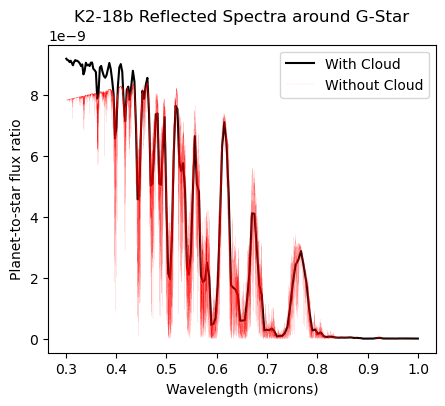

In [14]:
fig,ax = plt.subplots(1,1,figsize=[5,4])

wno, fpfs, albedo = res['all']
ax.plot(1e4/wno, fpfs, c='k', lw=1.5, label='With Cloud')
#for key in res:
#    if key == 'all':
#        continue
#    _, fpfs1 = res[key]
#    ax.fill_between(1e4/wno,fpfs,fpfs1,label=key,alpha=0.3)

#wno_no_cloud_grid_150, fpfs_no_cloud_grid_150 = jdi.mean_regrid(wno_no_cloud, fpfs_no_cloud, R=150)
ax.plot(1e4/wno_no_cloud, fpfs_no_cloud, c='red', lw=.05, ls='--', label='Without Cloud')
#ax.set_xlim(0.3,1)
#ax.set_ylim(0e-10,10e-9)
ax.set_ylabel('Planet-to-star flux ratio')
ax.set_xlabel('Wavelength (microns)')
ax.set_title('K2-18b Reflected Spectra around G-Star')
ax.legend()

plt.savefig('old_opacities.pdf',bbox_inches='tight')
plt.show()

In [15]:
def earth_spectrum(opacity, atmosphere_kwargs={}):

    earth = jdi.inputs()
    
    # Phase angle 
    earth.phase_angle(0) #radians
    
    # Define gravity
    earth.gravity(radius=1, radius_unit=jdi.u.Unit('R_earth'),
                 mass =1, mass_unit=jdi.u.Unit('M_earth')) #any astropy units available
    earth.approx(raman="none")
    
    # Define star 
    earth.star(opacity,5000,0,4.0,semi_major=1, 
               semi_major_unit=u.Unit('au')) 

    # P-T-Composition
    nlevel = 90 
    P = np.logspace(-6, 0, nlevel)
    df_atmo = earth.TP_line_earth(P , nlevel = nlevel)
    df_atmo_earth =  pd.DataFrame({
        'pressure':df_atmo['pressure'].values,
        'temperature':df_atmo['temperature'].values,
        "N2":np.logspace(-6,0,nlevel)*0+0.79,
        "O2":np.logspace(-6,0,nlevel)*0+0.21,
        "O3":np.logspace(-6,0,nlevel)*0+7e-7,
        "H2O":np.logspace(-6,0,nlevel)*0+3e-3,
        "CO2":np.logspace(-6,0,nlevel)*0+300e-6,
        "CH4":np.logspace(-6,0,nlevel)*0+1.7e-6
    })
    if 'exclude_mol' in atmosphere_kwargs:
        sp = atmosphere_kwargs['exclude_mol'][0]
        if sp in df_atmo_earth:
            df_atmo_earth[sp] *= 0
    # earth.atmosphere(df=df_atmo_earth, **atmosphere_kwargs)
    earth.atmosphere(df=df_atmo_earth)
    earth.surface_reflect(0.1,opacity.wno)

    # Cloud free spectrum
    df_cldfree = earth.spectrum(opacity,calculation='reflected',full_output=True)

    # Clouds
    ptop = 0.6
    pbot = 0.7
    logdp = np.log10(pbot) - np.log10(ptop)  
    log_pbot = np.log10(pbot)
    earth.clouds(w0=[0.99], g0=[0.85], 
                 p = [log_pbot], dp = [logdp], opd=[10])

    # Cloud spectrum
    df_cld = earth.spectrum(opacity,full_output=True)

    # Average the two spectra
    wno, alb, fpfs, albedo = df_cldfree['wavenumber'],df_cldfree['albedo'],df_cldfree['fpfs_reflected'], df_cldfree['albedo']
    wno_c, alb_c, fpfs_c, albedo_c = df_cld['wavenumber'],df_cld['albedo'],df_cld['fpfs_reflected'], df_cld['albedo']
    _, albedo = jdi.mean_regrid(wno, 0.5*albedo+0.5*albedo_c,R=140)
    wno, fpfs = jdi.mean_regrid(wno, 0.5*fpfs+0.5*fpfs_c,R=140)
    

    return wno, fpfs, albedo

def make_case_earth(opacity):
    species = ['O2','H2O','CO2','O3','CH4']
    # species = []

    res = {}
    res['all'] = earth_spectrum(opacity)
    for sp in species:
        tmp = earth_spectrum(opacity, atmosphere_kwargs={'exclude_mol': [sp]})
        res[sp] = tmp[:2]

    return res
    

In [16]:
opacity = jdi.opannection(wave_range=[0.1,2.0],
                          filename_db=ck_db_path)
res1 = make_case_earth(opacity)

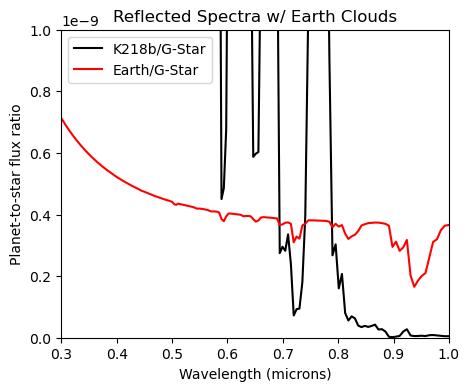

In [17]:
fig,ax = plt.subplots(1,1,figsize=[5,4])

wno_earth, fpfs_earth, albedo_earth = res1['all']
wno_K218b_clouds, fpfs_K218b_clouds, albedo_K218b_clouds = res['all']
ax.plot(1e4/wno_K218b_clouds, fpfs_K218b_clouds, c='k', lw=1.5, label='K218b/G-Star')
ax.plot(1e4/wno_earth, fpfs_earth, c='red', lw=1.5, label='Earth/G-Star')
ax.set_xlim(0.3,1)
ax.set_ylim(0e-10,10e-10)
ax.set_ylabel('Planet-to-star flux ratio')
ax.set_xlabel('Wavelength (microns)')
ax.set_title('Reflected Spectra w/ Earth Clouds')
ax.legend()

plt.savefig('Earth_K218b_clouds_RS_zoomedin.pdf',bbox_inches='tight')
plt.show()

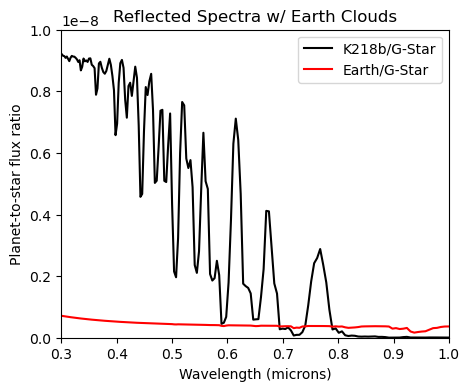

In [18]:
fig,ax = plt.subplots(1,1,figsize=[5,4])

wno_earth, fpfs_earth, albedo_earth = res1['all']
wno_K218b_clouds, fpfs_K218b_clouds, albedo_K218b_clouds = res['all']
ax.plot(1e4/wno_K218b_clouds, fpfs_K218b_clouds, c='k', lw=1.5, label='K218b/G-Star')
ax.plot(1e4/wno_earth, fpfs_earth, c='red', lw=1.5, label='Earth/G-Star')
ax.set_xlim(0.3,1)
ax.set_ylim(0e-10,10e-9)
ax.set_ylabel('Planet-to-star flux ratio')
ax.set_xlabel('Wavelength (microns)')
ax.set_title('Reflected Spectra w/ Earth Clouds')
ax.legend()

plt.savefig('Earth_K218b_clouds_RS.pdf',bbox_inches='tight')
plt.show()

### Conclusions
- Change the phase of the mini-neptune for the spectrums to be closer in magnitude.